# MNIST Convolutional Neural Network in Tensorflow

Author: Juvid Aryaman

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
sys.path.append("..")
import utls
utls.reset_plots()

MNIST is a dataset of 28$\times$28 handwritten digits. The dataset comes shipped with tensorflow, so let's load it up and have a look.

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

Expand the final dimension to a single channel

In [4]:
x_train = np.expand_dims(x_train,axis=3)
x_test = np.expand_dims(x_test,axis=3)
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [5]:
y_train.shape, y_test.shape

((60000,), (10000,))

In [6]:
n_train = x_train.shape[0]
n_test = x_test.shape[0]

Plot some example images

In [7]:
from matplotlib import cm

Digit: 8


/home/juvid/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


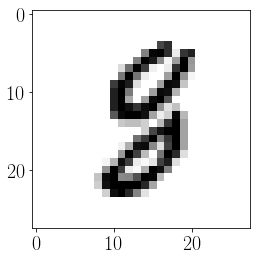

In [8]:
example = np.random.choice(np.arange(n_train))

image = x_train[example,:,:,0]
label = y_train[example]

plt.imshow(image, cmap = cm.binary)
print("Digit: {}".format(label))

Now we encode the data labels as one-hot vectors

In [9]:
y_train[:20]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
      dtype=uint8)

In [10]:
def one_hot(labels):
    """
    Encodes a list of labels ranging between (0-9) as one-hot vectors.
    0 -> [1,0,0,0,0,0,0,0,0,0]
    9 -> [0,0,0,0,0,0,0,0,0,1]
    """
    one_hot_labels = []
    for num in labels:
        one_hot = [0.0]*10
        one_hot[num] = 1.0
        one_hot_labels.append(one_hot)
    return np.array(one_hot_labels).astype(np.float32)

In [11]:
y_train_oh = one_hot(y_train)
y_test_oh = one_hot(y_test)
y_train_oh.shape, y_test_oh.shape

((60000, 10), (10000, 10))

In [12]:
y_train[0],y_train_oh[0]

(5, array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32))

Take a small sample dataset for preliminary debugging/architecture 

In [13]:
x_sample = x_train[0:20,:,:,:]
y_sample_oh = y_train_oh[0:20]
x_sample.shape, y_sample_oh.shape

((20, 28, 28, 1), (20, 10))

## Build convolutional neural network

In [65]:
class CNN_MNIST:
    """
    Define a convolutional neural network for the MNIST dataset
    
    Params
    ------------
    wd_factor : A double, the L2 regularisation factor for model parameters
    learning_rate : A double, the learning rate for the Adam optimiser    
    
    """
    def __init__(self, wd_factor, learning_rate):
        self.wd_factor = wd_factor # weight decay factor (L2 regulariser)
        self.learning_rate = learning_rate
        self.train_pointer = 0 # for mini-batch housekeeping
        self.test_pointer = 0
        
        self.input = tf.placeholder(dtype=tf.float32, shape=[None,28,28,1],name="input")
        self.ground_truth = tf.placeholder(dtype=tf.float32, shape=[None,10],name="ground_truth")
        print(self.input)
        
        # For batch norm and dropout, which work differently depending on whether you're 
        # training or testing
        
        self.is_training = tf.placeholder(tf.bool, name="is_training")
        
        self._build_graph()
        
    def _build_graph(self):
        """
        Create the convolutional neural network using the Adam optimiser and cross entropy loss
        """
        weights = [] # for weight decay
        
        with tf.variable_scope("layers"):
            h = tf.layers.conv2d(self.input, 32, (3,3), strides=(1,1), padding="same",
                                 data_format="channels_last", activation=None, use_bias=True,
                                 kernel_initializer=tf.glorot_uniform_initializer(),name='conv1')
            print(h)
            h = tf.layers.batch_normalization(h, training=self.is_training)
            print(h)
            h = tf.nn.relu(h) # activation                        
            
            h = tf.layers.conv2d(h, 64, (3,3), strides=(1,1), padding="same",
                                 data_format="channels_last", activation=None, use_bias=True,
                                 kernel_initializer=tf.glorot_uniform_initializer(),name='conv2') 
            print(h)
            h = tf.layers.batch_normalization(h, training=self.is_training)
            print(h)
            h = tf.nn.relu(h) # activation            
            h = tf.layers.max_pooling2d(h, (3,3), (3,3), padding='valid') # Downsample           
            
            h = tf.layers.conv2d(h, 64, (3,3), strides=(1,1), padding="same",
                                 data_format="channels_last", activation=None, use_bias=True,
                                 kernel_initializer=tf.glorot_uniform_initializer(),name='conv3')
            print(h)
            h = tf.layers.batch_normalization(h, training=self.is_training)
            print(h)
            h = tf.nn.relu(h) # activation            
            h = tf.layers.max_pooling2d(h, (3,3), (3,3), padding='valid') # Downsample           
            h = tf.layers.flatten(h) # flatten before dense layers
            
            
            # Fully connected layers
            h = tf.layers.dense(h, 32, kernel_initializer=tf.glorot_uniform_initializer(),
                               activation=tf.nn.relu, name='dense1')      
            print(h)
            h = tf.layers.dropout(h, rate=0.25, training=self.is_training, name="dropout1")
            
            
            
            self.logits = tf.layers.dense(h, 10, kernel_initializer=tf.glorot_uniform_initializer(),
                               activation=tf.identity, name='dense2') # linear output for the loss function            
            print(self.logits)
            self.prediction = tf.nn.softmax(self.logits, name="softmax_prediction")
        
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits,
                                                                                 labels=self.ground_truth))
            self.loss += self.weight_decay() # penalise weights with L2 norm
        
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        
        # When using batch-norm need to do this
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            self.train_op = self.optimizer.minimize(self.loss)
        
    def weight_decay(self):
        """
        Append the L2 penalty onto the loss function
        """
        loss = 0
        for v in tf.global_variables():
            if 'Adam' in v.name:
                continue # do not punish optimizer variables
            elif 'kernel' in v.name:
                loss += self.wd_factor * tf.nn.l2_loss(v)
        print(loss)
        return loss
    
    def train_minibatch(self, samples, labels, batch_size):
        """
        Take a mini-batch from the training dataset
        """
        if self.train_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.train_pointer: self.train_pointer + batch_size]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer += batch_size
        else:
            samples_minibatch = samples[self.train_pointer:]
            labels_minibatch = labels[self.train_pointer:]
            self.train_pointer += 0 # reset
        return samples_minibatch, labels_minibatch
    
    def train(self, train_samples, train_labels, train_batch_size, iteration_steps, import_from_previous=False):
        """
        Train the model
        
        Params
        ----------
        
        train_samples: A numpy matrix containing the training data
        train_labels: A numpy vector containing the labels corresponding to train_samples
        train_batch_size: An int. The number of data points per mini-batch
        iteration_steps: An int. The number of mini-batch training steps
        import_from_previous: A bool. Load a previous model and train
        
        Returns
        -----------
        
        losses: A numpy array, where the first column is the mini-batch index, and the 
                second column is the loss function
        """
        print('Start training....')
        losses = []
        
        with tf.Session() as sess:
            if import_from_previous:
                saver = tf.train.import_meta_graph("./model.meta") # import the model
                saver.restore(sess, './model') # populate with weights  
            else:
                sess.run(tf.global_variables_initializer())
                saver = tf.train.Saver() # for saving models
            
            for i in range(iteration_steps):
                samples, labels = self.train_minibatch(train_samples, train_labels, train_batch_size)
                feed_dict = {self.input: samples, self.ground_truth: labels, self.is_training: True}
                _, loss = sess.run([self.train_op, self.loss], feed_dict=feed_dict)
                if i % 50 == 0:
                    print("Minibatch loss at step {}: {}".format(i, loss))
                    losses.append([i, loss])
            saver.save(sess, './model') # save the model, generating 4 files
        return np.array(losses)
    
    def test_minibatch(self, samples, labels, batch_size):
        """
        Take a mini-batch from the test dataset
        """
        if self.test_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.test_pointer: self.test_pointer + batch_size]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer += batch_size
            end_of_epoch = False
        else:
            samples_minibatch = samples[self.test_pointer:]
            labels_minibatch = labels[self.test_pointer:]
            self.test_pointer += 0 # reset
            end_of_epoch = True
        return samples_minibatch, labels_minibatch, end_of_epoch
    
    def test(self, test_samples, test_labels, test_batch_size):
        """
        Load a model, feed it test data, and determine the loss
        
        Params:
        ---------------
        test_samples: A numpy array, containing the test data
        test_labels: A numpy vector, containing the test labels
        test_batch_size: An int, the number of data points per mini-batch
        """
        end_of_epoch = False
        losses = []
        
        with tf.Session() as sess:
            saver = tf.train.import_meta_graph("./model.meta") # import the model
            saver.restore(sess, './model') # populate with weights            
            while not end_of_epoch: # run graph
                samples, labels, end_of_epoch = self.test_minibatch(test_samples, 
                                                                    test_labels, test_batch_size)
                feed_dict = {self.input: samples, self.ground_truth: labels, self.is_training: False}                
                losses.append(sess.run(self.loss, feed_dict=feed_dict))
            print("Average test loss: {}".format(np.mean(losses)))



In [66]:
WD_FACTOR = 0.0001
LEARNING_RATE = 0.001
tf.reset_default_graph()
model = CNN_MNIST(WD_FACTOR, LEARNING_RATE)

Tensor("input:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("layers/conv1/BiasAdd:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("layers/batch_normalization/cond/Merge:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("layers/conv2/BiasAdd:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("layers/batch_normalization_1/cond/Merge:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("layers/conv3/BiasAdd:0", shape=(?, 9, 9, 64), dtype=float32)
Tensor("layers/batch_normalization_2/cond/Merge:0", shape=(?, 9, 9, 64), dtype=float32)
Tensor("layers/dense1/Relu:0", shape=(?, 32), dtype=float32)
Tensor("layers/dense2/Identity:0", shape=(?, 10), dtype=float32)
Tensor("loss/add_4:0", shape=(), dtype=float32)


In [67]:
tf.global_variables()

[<tf.Variable 'layers/conv1/kernel:0' shape=(3, 3, 1, 32) dtype=float32_ref>,
 <tf.Variable 'layers/conv1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization/gamma:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization/moving_mean:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization/moving_variance:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'layers/conv2/kernel:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
 <tf.Variable 'layers/conv2/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization_1/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization_1/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization_1/moving_mean:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization_1/moving_variance:0' shape=(64,) dtype=float32_ref>,
 <tf.

In [68]:
def count_trainable_params():
    total_parameters = 0
    for variable in tf.trainable_variables():         
        shape = variable.get_shape()        
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value        
        total_parameters += variable_parameters
    print(total_parameters)

In [69]:
count_trainable_params()

74858


About a factor of 10 fewer params than the MLP

## Train model

In [70]:
TRAIN_BATCH_SIZE = 128

Define a learning schedule whereby we gradually reduce the learning rate with iterations

In [71]:
learning_schedule = [[2000,0.1],[2000,0.01],[2000,0.001],[4000,0.0001]]
#learning_schedule = [[400,0.001]]

In [72]:
start = time.time()

for i, vals in enumerate(learning_schedule):
    ITERATIONS = vals[0]
    LR = vals[1]
    if i == 0:
        model.learning_rate = LR
        #losses = model.train(x_sample, y_sample_oh, TRAIN_BATCH_SIZE, ITERATIONS)
        losses = model.train(x_train, y_train_oh, TRAIN_BATCH_SIZE, ITERATIONS)
    else:

        #losses_new = model.train(x_sample, y_sample_oh, TRAIN_BATCH_SIZE, ITERATIONS, import_from_previous = True)
        losses_new = model.train(x_train, y_train_oh, TRAIN_BATCH_SIZE, ITERATIONS, import_from_previous = True)
        losses_new[:,0] += losses[-1,0] + TRAIN_BATCH_SIZE
        losses = np.vstack((losses,losses_new))
end_time = time.time()


Start training....
Minibatch loss at step 0: 3.396852970123291
Minibatch loss at step 50: 0.9064825773239136
Minibatch loss at step 100: 0.4513855576515198
Minibatch loss at step 150: 0.28895828127861023
Minibatch loss at step 200: 0.2646741569042206
Minibatch loss at step 250: 0.3018289804458618
Minibatch loss at step 300: 0.20024149119853973
Minibatch loss at step 350: 0.2687474191188812
Minibatch loss at step 400: 0.23494209349155426
Minibatch loss at step 450: 0.1456923633813858
Minibatch loss at step 500: 0.03704576939344406
Minibatch loss at step 550: 0.03524889796972275
Minibatch loss at step 600: 0.02391580305993557
Minibatch loss at step 650: 0.04079912602901459
Minibatch loss at step 700: 0.01618035137653351
Minibatch loss at step 750: 0.0207089614123106
Minibatch loss at step 800: 0.014665616676211357
Minibatch loss at step 850: 0.017326626926660538
Minibatch loss at step 900: 0.014966344460844994
Minibatch loss at step 950: 0.013495679944753647
Minibatch loss at step 1000: 

Minibatch loss at step 2100: 0.005867016036063433
Minibatch loss at step 2150: 0.011057939380407333
Minibatch loss at step 2200: 0.010932499542832375
Minibatch loss at step 2250: 0.008525611832737923
Minibatch loss at step 2300: 0.005935034714639187
Minibatch loss at step 2350: 0.010989145375788212
Minibatch loss at step 2400: 0.015233572572469711
Minibatch loss at step 2450: 0.005936314817517996
Minibatch loss at step 2500: 0.007299234624952078
Minibatch loss at step 2550: 0.00842951238155365
Minibatch loss at step 2600: 0.00927777960896492
Minibatch loss at step 2650: 0.005728002171963453
Minibatch loss at step 2700: 0.0068631223402917385
Minibatch loss at step 2750: 0.006794311571866274
Minibatch loss at step 2800: 0.005702583119273186
Minibatch loss at step 2850: 0.0066250162199139595
Minibatch loss at step 2900: 0.006104726344347
Minibatch loss at step 2950: 0.006423786282539368
Minibatch loss at step 3000: 0.00523808877915144
Minibatch loss at step 3050: 0.005619672127068043
Mini

In [73]:
print("Training time: {}s".format(end_time - start))

Training time: 8144.678204059601s


## Plot learning curve

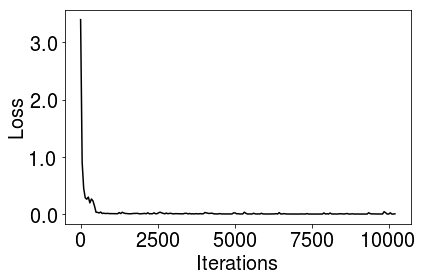

In [74]:
iterations = losses[:,0]
train_loss = losses[:,1]

fig, ax = plt.subplots(1,1)
utls.remove_tex_axis(ax, ytick_fmt="%.1f")
ax.plot(iterations, train_loss,'-k')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
plt.tight_layout()

## Test network predictions

In [75]:
TEST_BATCH_SIZE = 128

In [77]:
model.test(x_test,y_test_oh, TEST_BATCH_SIZE)

INFO:tensorflow:Restoring parameters from ./model
Average test loss: 1.781084656715393


Loss was 2.25 for MLP, so it's an improvement...

INFO:tensorflow:Restoring parameters from ./model
Test sample digit: 0


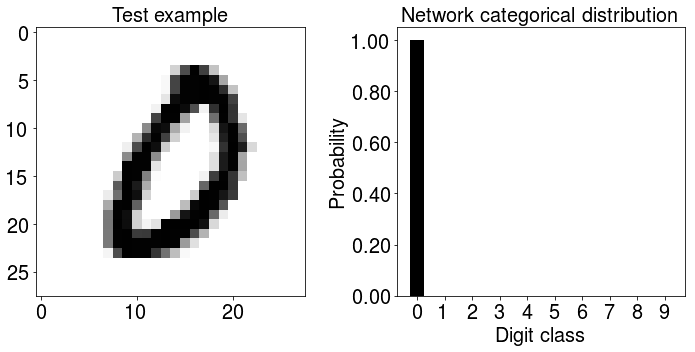

In [90]:
plt.close('all')
example = np.random.choice(n_test)

sample = x_test[example]
label = y_test_oh[example]
feed_dict = {model.input: np.expand_dims(sample, axis=0), 
             model.ground_truth: np.expand_dims(label,axis=0),
            model.is_training: False}

digit = np.where(label==1.0)[0][0]

with tf.Session() as sess:
    saver = tf.train.import_meta_graph("./model.meta")
    saver.restore(sess, './model')
    prediction = sess.run(model.prediction, feed_dict = feed_dict)[0]

fig, axs = plt.subplots(1,2, figsize=(2*5,5))
axs = axs.ravel()

ax = axs[0]
utls.remove_tex_axis(ax)
ax.imshow(x_test[example,:,:,0],cmap=cm.binary)
ax.set_title('Test example')

classes = np.arange(10)
width = 0.5

ax = axs[1]

ax.bar(classes, prediction, width, color='Black')
utls.remove_tex_axis(ax,ytick_fmt="%.2f")
ax.set_xticks(classes)
ax.set_xticklabels([str(x) for x in np.arange(10)])
ax.set_ylabel('Probability')
ax.set_xlabel('Digit class')
ax.set_title('Network categorical distribution')

plt.tight_layout()
print('Test sample digit: {}'.format(digit))
